In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allison.nn.layers import LayerDense
from allison.nn.models import NeuralNetwork
from allison.utils.functions.data import train_test_split
from allison.utils.functions.activation import sigmoid,softmax,tanh,relu,linear
from allison.utils.metrics import r2_score
from allison.utils.functions.loss import mean_squared_error
from allison.optimizers.sgd import SGD,SGDMomentum

Dataset

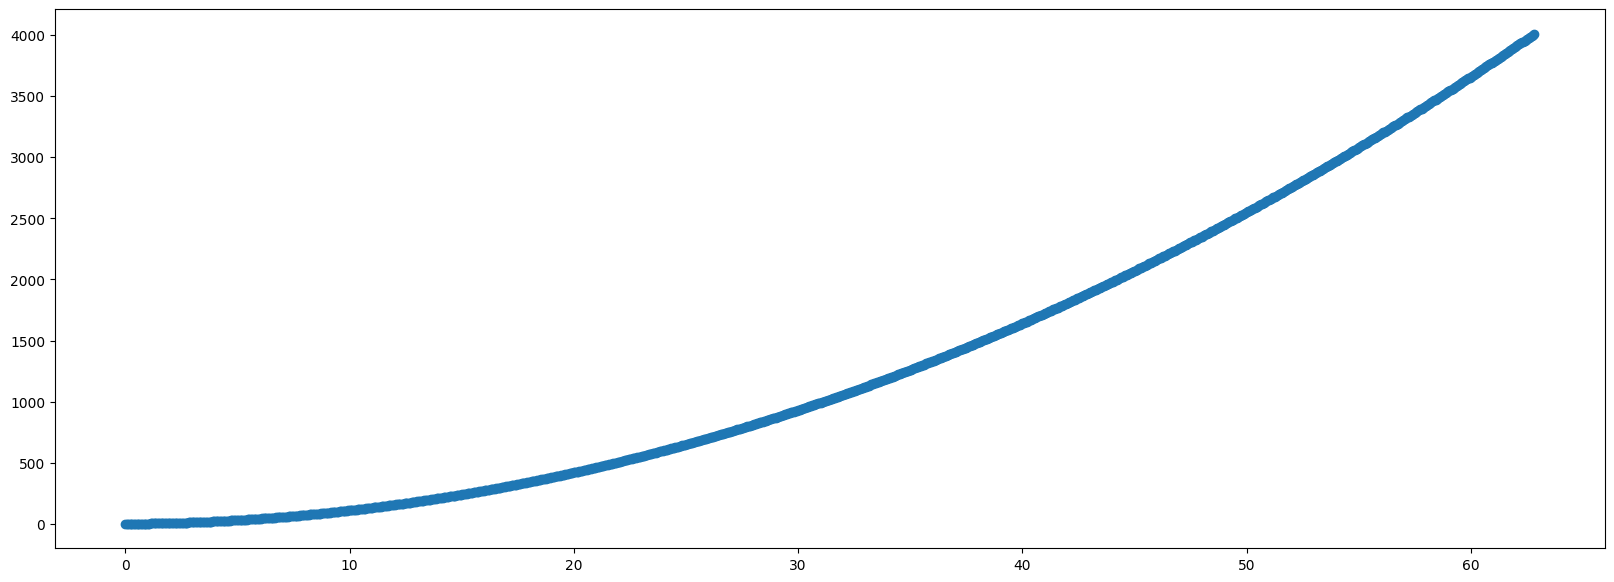

In [2]:
points = 1000

x1 = np.linspace(0,20*np.pi,points)
x2 = np.linspace(0,20*np.pi,points)

y =  x1**2 + x2

plt.figure(figsize=(20, 7))
plt.scatter(x2, y)

In [3]:

df=pd.DataFrame({
    "x1":x1,
    'x2':x2,
    "y":y,
})
df.head()

,x1,x2,y
0,0.000000,0.000000,0.000000
1,0.062895,0.062895,0.066850
2,0.125789,0.125789,0.141612
3,0.188684,0.188684,0.224286
4,0.251579,0.251579,0.314871


# Preprocess

Split data for train and test

In [4]:
data_train, data_test = train_test_split(df,test_size=0.2)
features = ["x1","x2"]
labels = "y"

X_train = data_train[features].to_numpy()
Y_train=data_train[labels].to_numpy(int)
print(X_train.shape,Y_train.shape)

X_test = data_test[features].to_numpy()
Y_test=data_test[labels].to_numpy(int)
print(X_test.shape,Y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


# Train

In [5]:
model = NeuralNetwork(mean_squared_error,r2_score)
model.add_layer(LayerDense(2,4,relu))
model.add_layer(LayerDense(4,2,relu))
model.add_layer(LayerDense(2,1,linear))
model.summary()

Layer:1, neurons:4, input:(n,2), weights:(2,4), output:(n,4), activation:relu 

Layer:2, neurons:2, input:(n,4), weights:(4,2), output:(n,2), activation:relu 

Layer:3, neurons:1, input:(n,2), weights:(2,1), output:(n,1), activation:linear 

Total -> Layers:3, neurons:7, weights:18, bias:7 params:25 

Loss function: mean_squared_error 

Metric: r2_score 



In [6]:
# optimizer = SGD(learning_rate=0.000000000001)
optimizer = SGDMomentum(learning_rate=0.000000000005,momentum=0.9)

In [7]:
steps = 200
iters = 10

r2_train = 0
r2_test = 0

for step in range(1,steps+1):

    if r2_train > 95.0 and r2_test > 95.0:
        break
    
    for _ in range(iters):
        output = model.forward(X_train)
        model.backward(output,Y_train,X_train)
        optimizer.update(model)
    
    r2_train = model.evaluate(X_train,Y_train)
    r2_test = model.evaluate(X_test,Y_test)


    print(f"Step: {step:3d} R2_train: {r2_train:7.3f}% R2_test: {r2_test:7.3f}%")

Step:   1 R2_train: -471438.665% R2_test: -441992.402%
Step:   2 R2_train: -304385.262% R2_test: -285179.461%
Step:   3 R2_train: -189338.892% R2_test: -177247.671%
Step:   4 R2_train: -117547.669% R2_test: -109936.803%
Step:   5 R2_train: -73041.946% R2_test: -68235.283%
Step:   6 R2_train: -45231.648% R2_test: -42195.806%
Step:   7 R2_train: -27766.442% R2_test: -25856.370%
Step:   8 R2_train: -16809.803% R2_test: -15616.488%
Step:   9 R2_train: -9985.154% R2_test: -9246.610%
Step:  10 R2_train: -5788.258% R2_test: -5336.079%
Step:  11 R2_train: -3253.948% R2_test: -2980.128%
Step:  12 R2_train: -1759.422% R2_test: -1595.198%
Step:  13 R2_train: -903.518% R2_test: -805.615%
Step:  14 R2_train: -430.176% R2_test: -371.770%
Step:  15 R2_train: -178.701% R2_test: -143.450%
Step:  16 R2_train: -50.821% R2_test: -28.943%
Step:  17 R2_train:  11.407% R2_test:  25.685%
Step:  18 R2_train:  40.515% R2_test:  50.568%
Step:  19 R2_train:  53.675% R2_test:  61.474%
Step:  20 R2_train:  59.362% 

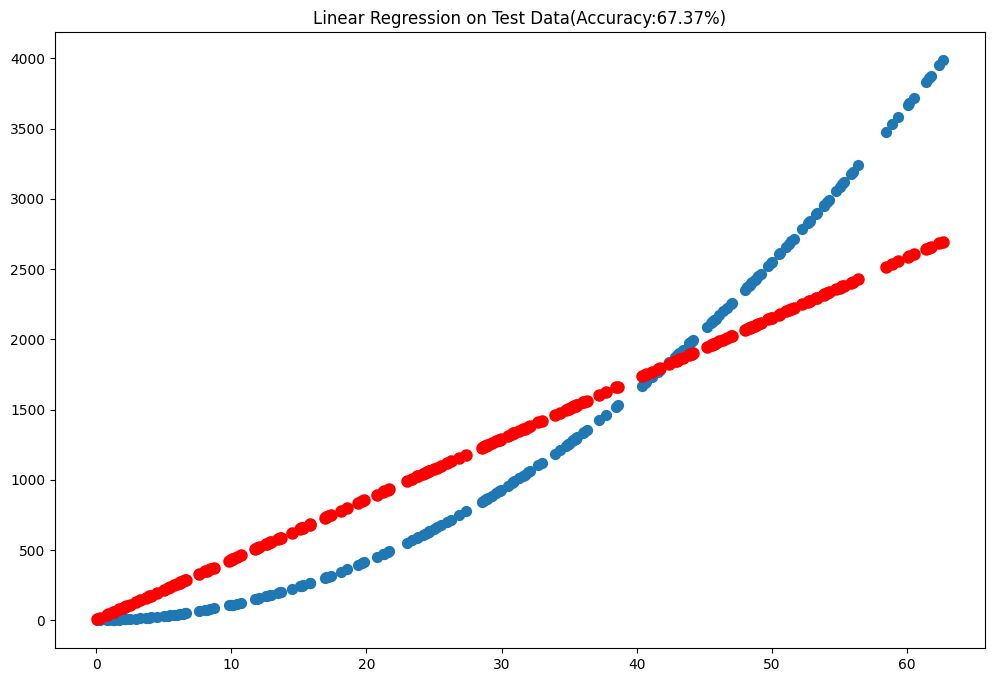

In [8]:
plt.figure(figsize=(12,8))

plt.scatter(X_test[:,0],Y_test,s=50)
plt.scatter(X_test[:,0],model.predict(X_test), lw=3, c='red')
plt.title(f'Linear Regression on Test Data(Accuracy:{model.evaluate(X_test, Y_test):.2f}%)')
plt.show()